In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39329")
client

<Client: 'tcp://127.0.0.1:39329' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:35841' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
ddir = '/tank/groups/climode/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1574640+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

ntheta = 36
xo = 50e3
# s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
#                  coords={'scale':np.arange(.5,10.5,.5)}
#                 )

# Wavelet

## Uniform grid

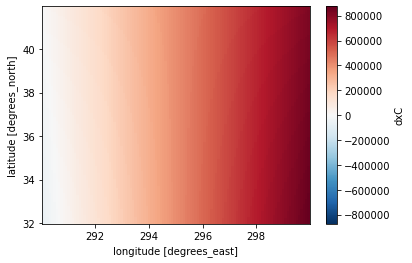

In [8]:
reg = 0
dg = 1
ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (100)), 
                     grid_dir=gdir,
                     prefix=['snap_diagOcn'], delta_t=2e2,
                     iters=1419120, 
                    ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                       YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                       XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                       XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                      ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

grid = Grid(ds, periodic=[])

ny, nx = ds.dxC.shape
xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
xT = xT - xT.isel(XC=nx//2)
(xT - xT.isel(YC=-1,XC=0)).plot()
plt.show()

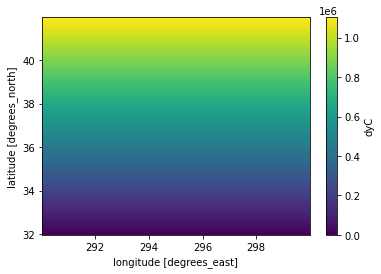

In [17]:
(yT - yT.isel(YC=0)).plot()
plt.show()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[-1.35558669e-09, -7.44449759e-09,  4.97001190e-09,
         2.07592929e-08,  2.60853410e-08,  2.97843661e-08,
         1.62543154e-08,  3.69073451e-09,  1.36418317e-09,
         9.96845285e-09,  5.40915342e-09, -1.02775675e-08,
        -1.54183199e-08, -9.73288077e-09,  7.02092186e-09,
         1.72339294e-08,  1.79962865e-08,  8.41678449e-09],
       [ 6.36584354e-10, -1.33614825e-09,  1.10995068e-09,
         5.32694830e-09,  8.06005204e-09,  9.61597587e-09,
         4.67498301e-09,  5.87486613e-10, -9.06255496e-11,
         1.06264910e-09, -4.63184522e-10, -3.55783755e-09,
        -5.23234083e-09, -3.96769752e-09,  9.11932515e-10,
         4.19827955e-09,  5.57771053e-09,  3.91304508e-09],
       [-2.86432121e-11, -4.61500254e-11,  4.02939530e-11,
         9.70511730e-11,  4.63188713e-10,  6.12725968e-10,
         7.05985660e-11, -3.25393924e-10, -2.81714155e-10,
        -3.63248979e-11, -3.39673704e-11, -1.72545482e-10,
        -2.217725

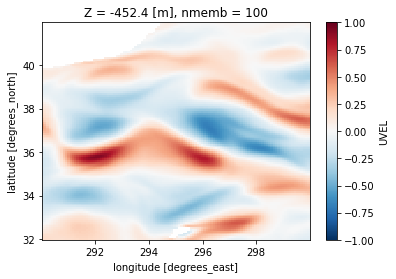

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


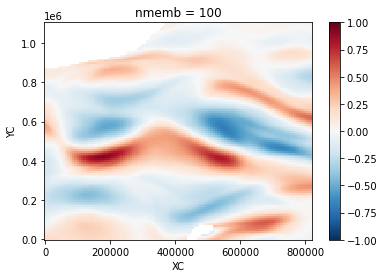

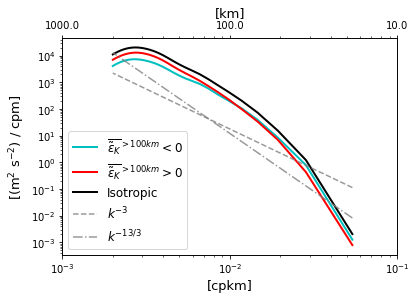

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[-1.95391412e-09, -2.39032286e-09, -1.08428895e-09,
        -2.70528705e-09, -4.27151902e-09, -2.35465769e-09,
         2.35861501e-09,  3.37806761e-09,  3.47356682e-09,
         1.19228945e-10, -4.27806978e-09, -1.00305012e-08,
        -1.36787751e-08, -5.19542680e-09,  4.86923089e-09,
         8.33379735e-09,  4.56391254e-09,  1.45486126e-09],
       [-6.33965940e-10, -1.22265296e-09, -7.06713156e-10,
        -6.90492538e-10, -1.61237112e-09, -9.75060504e-10,
         4.42626577e-10,  7.92052465e-10,  6.87845523e-10,
        -2.69232077e-10, -1.29608509e-09, -2.68127628e-09,
        -4.13343585e-09, -1.78064199e-09,  1.69209573e-09,
         3.47187261e-09,  2.83235096e-09,  1.07645317e-09],
       [-8.50636093e-11, -5.73698770e-10, -7.35818371e-10,
        -6.78477336e-10, -9.27938065e-10, -4.42923301e-10,
         7.07991225e-11,  1.91684862e-10, -6.57398681e-12,
        -1.77710722e-10, -3.22386714e-10, -4.82115197e-10,
        -6.838469

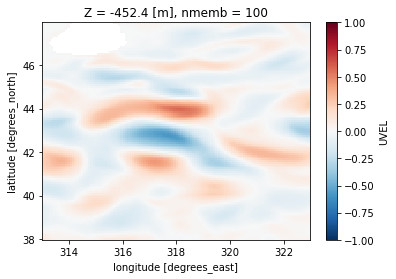

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


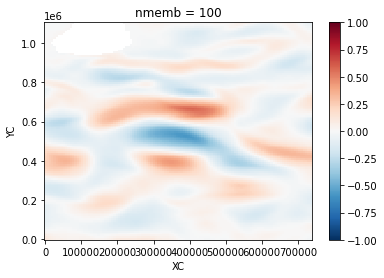

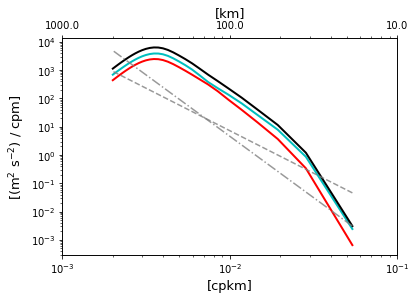

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[-4.45056602e-10, -1.94374554e-09, -2.78177052e-09,
        -3.51727643e-09, -4.27079139e-09, -4.04778964e-09,
        -2.82233331e-09, -1.01657920e-09, -2.99129700e-10,
         3.40780368e-11,  5.34341535e-10,  1.43266922e-09,
         2.64989644e-09,  3.52113797e-09,  3.67163004e-09,
         3.14087553e-09,  2.05415269e-09,  1.14498881e-09],
       [-2.29428174e-10, -8.66051447e-10, -1.08846278e-09,
        -1.35611856e-09, -1.72801504e-09, -1.48460075e-09,
        -9.90354417e-10, -4.64022613e-10, -2.05409181e-10,
        -1.68066899e-11,  1.43980486e-10,  5.26424445e-10,
         9.67841783e-10,  1.29575962e-09,  1.42499074e-09,
         1.23735531e-09,  7.56861133e-10,  3.70202489e-10],
       [-3.46436353e-13, -5.49099121e-11, -8.29795864e-11,
        -1.03865236e-10, -7.56479586e-11, -3.19943447e-11,
        -1.52040359e-12,  9.33479957e-12,  7.69680079e-12,
         4.24515052e-13, -1.69858517e-11, -1.00007082e-11,
         4.118917

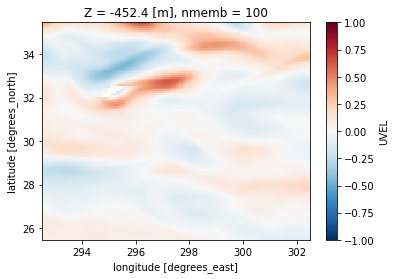

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


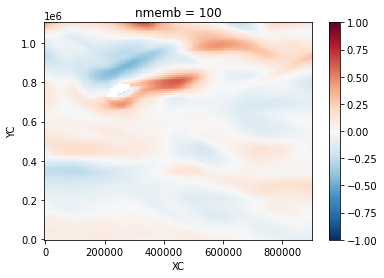

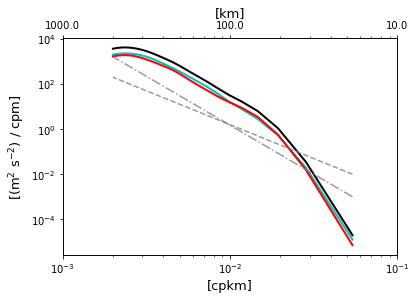

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[-2.23681752e-11, -1.34476011e-10, -2.23440798e-10,
        -3.27586820e-10, -2.33932606e-10, -1.24441856e-10,
        -5.79835258e-11, -9.30369126e-11, -4.48300393e-11,
        -8.06928550e-11, -1.31590646e-10, -1.27740389e-10,
        -1.47813699e-10, -1.37255096e-10,  2.09711686e-11,
         3.29887522e-11,  1.31755133e-10,  8.99065799e-11],
       [-9.63491406e-13, -4.97695699e-11, -8.17498541e-11,
        -1.46852929e-10, -1.37439450e-10, -6.87497609e-11,
        -3.52178394e-11, -3.87099255e-11, -3.56711036e-11,
        -5.40965209e-11, -4.50046096e-11,  1.29627492e-11,
         9.62881563e-13,  1.89903952e-12,  4.40351875e-11,
         7.51331702e-11,  6.81520796e-11,  4.26244624e-11],
       [-3.97944855e-12, -7.46088285e-12, -1.31648520e-11,
        -2.02804847e-11, -3.01420797e-11, -1.85462565e-11,
        -5.58585718e-12, -6.10847399e-12, -2.57331969e-12,
        -5.26474461e-12, -2.85997063e-12, -3.29993001e-12,
        -1.320701

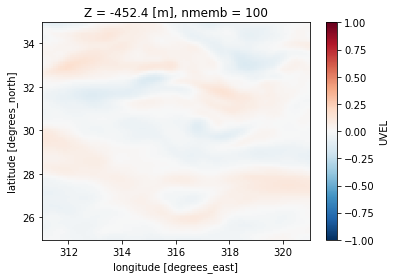

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


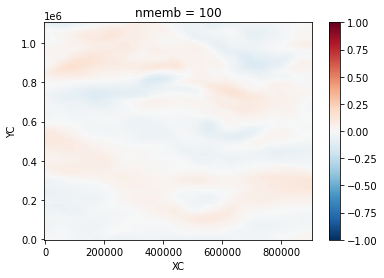

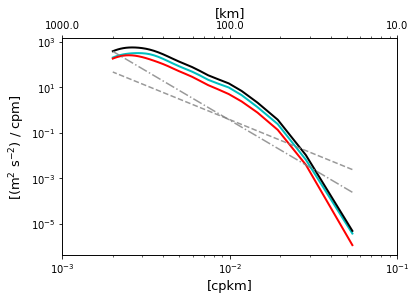

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[ 2.35321943e-11, -3.47629326e-11, -4.68560967e-12,
         4.47850509e-11, -1.57969280e-11,  5.86592284e-11,
         1.99477564e-10,  2.59752441e-10,  1.16282669e-10,
        -3.31888311e-11, -1.56513618e-10, -2.36402552e-10,
        -1.25347702e-10,  6.55042979e-11,  9.18475214e-11,
         9.18993025e-11,  9.54720153e-11,  3.74797041e-11],
       [-4.86690998e-12, -1.91966196e-11,  9.83929684e-12,
         1.16694951e-11, -4.56225270e-11, -2.68535753e-11,
         2.61122860e-11,  1.10681681e-11, -1.00016669e-11,
        -1.76274982e-11, -3.80687158e-11, -1.03082523e-11,
         4.77802016e-12,  1.44951996e-11,  3.50710965e-11,
         8.24912493e-12,  3.49224246e-11, -5.73611043e-12],
       [ 8.37983104e-12, -1.06645629e-11,  9.91972807e-14,
         2.60014558e-12, -1.61137515e-11,  2.05797035e-11,
         3.61586611e-11,  4.37527750e-11,  3.90306479e-11,
         1.91884959e-11, -5.42881474e-12, -2.92071470e-11,
        -3.452776

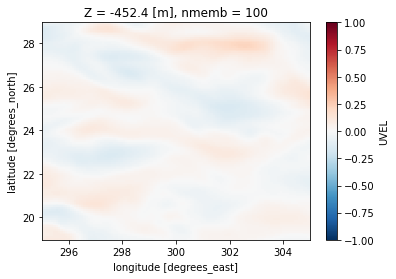

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


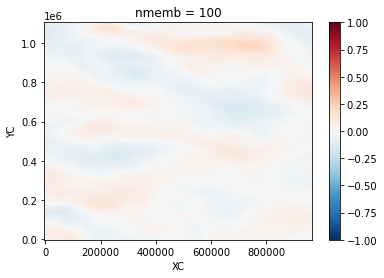

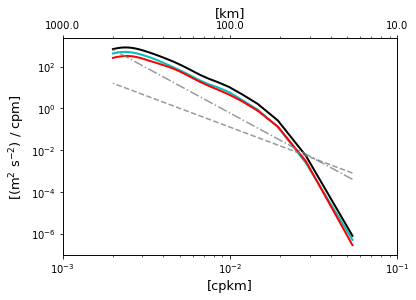

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (Z: 3, angle: 18)>
array([[-7.48900954e-12, -5.01051255e-11, -4.72801442e-11,
        -2.98322794e-11, -3.28174449e-11,  3.66846512e-12,
         2.31993165e-11,  2.65546755e-11,  1.09773991e-11,
        -7.16543057e-12, -2.16374532e-11, -1.98504244e-11,
        -1.16160993e-11,  3.37504590e-11,  8.07112145e-11,
         6.96715929e-11,  4.90696677e-11,  6.42805630e-11],
       [-2.93244572e-12, -3.02301437e-13,  1.24121170e-11,
         2.15906219e-11,  1.33263882e-11,  5.50995572e-11,
         6.25000172e-11,  5.55324322e-11,  1.78190757e-11,
        -8.02532033e-12, -1.40190290e-11, -2.85046492e-11,
        -4.24598224e-11, -3.40106284e-11, -2.37286357e-11,
        -3.46962113e-11, -1.05466248e-11,  2.60442199e-12],
       [ 3.01171869e-12,  8.61795014e-13,  8.33010316e-12,
         2.37792412e-11,  1.45815140e-11,  2.77674646e-11,
         3.85344026e-11,  3.18752265e-11,  2.33407521e-11,
         1.80371317e-12, -4.59258398e-12, -9.54319144e-12,
        -1.954726

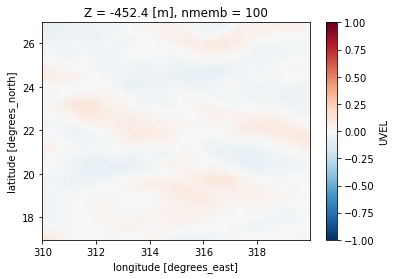

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00 <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00


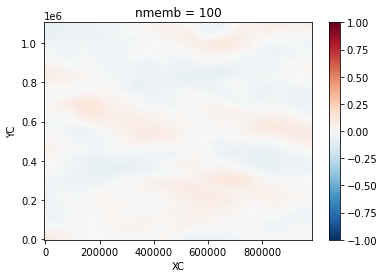

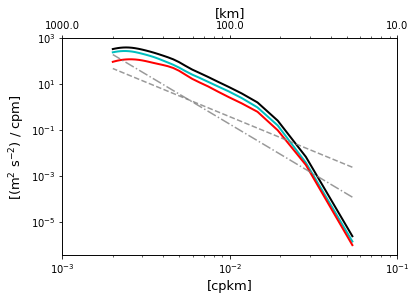

In [12]:
nmembs = np.arange(100,148)
xchunk = 100
ychunk = 100
dg = 1

yy = yystart

for reg in range(len(xs)):
    dsb = xr.open_zarr(op.join(savedir,'Snaps_EnsMean_0001419123.zarr')
                      ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                            YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                            XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                            XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                           )
    
    ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
    # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                           coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                          ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
            + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
           )
    Ak = (ds0.iso_uA + ds1.iso_vA
          # - (ds4.iso_uA + ds4.iso_vA)
          - MtE
         )
    piw = ((Ak) * dks).cumsum('scale').mean('nmemb')
    # piw = piw.where((piw.scale)**-1>=2e-5).where((piw.scale)**-1<=5e-4).mean('scale',skipna=True).compute()
    piw = piw.where((piw.scale)**-1<=1e-5).mean('scale',skipna=True).compute()
    print(piw)
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=1419123, 
                                ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                   YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                   XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                                   XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                                  )
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=1419123, 
                                               ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                                  YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                                  XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                                                  XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                                                 )
                           ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
        ds = ds.isel(XG=slice(None,-1))
    
    grid = Grid(ds, periodic=False)
    # print(ds,grid)

    up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                     'X',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
    vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                     'Y',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
    up.isel(nmemb=0,Z=1).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
    plt.show()

    xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    xT = (xT - xT.isel(XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    print(ds.dxC.mean(), ds.dyC.mean())
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = up.isel(nmemb=0,Z=1).shape
    ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
                      coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
                     )

    uterp = xr.DataArray(np.ones_like(up.isel(Z=1)), dims=up.isel(Z=1).dims,
                         coords={'nmemb':nmembs,
                                 # 'Z':up.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.ones_like(vp.isel(Z=1)), dims=vp.isel(Z=1).dims,
                         coords={'nmemb':nmembs,
                                 # 'Z':vp.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.ones_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), dims=ds.rA.dims,
                         coords={'YC':np.arange(0,N[-2]*dx,dx),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    #         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    iz = 1
    for nn in range(len(nmembs)):
#         for iz in range(len(up.Z)):

#             uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
#                                                     (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#                                                     ).isel(nmemb=nn,Z=iz).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 

#             vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
#                                                     (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#                                                     ).isel(nmemb=nn,Z=iz).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 
        uterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
                                           (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 

        vterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
                                           (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 
            
    Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
                     (xxx, yyy) 
                    ).T
    uterp = uterp / Aterp
    vterp = vterp / Aterp
    uterp.isel(nmemb=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
    plt.show()
    #             print(nn)


    iso_psU = xwavelet.wvlt_power_spectrum(
                    uterp.chunk({'nmemb':1}), ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_psV = xwavelet.wvlt_power_spectrum(
                    vterp.chunk({'nmemb':1}), ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    fig, ax = plt.subplots()
    ax2 = ax.twiny()
    ax.plot((iso_psU.scale)**-1*1e3, 
            .5*(iso_psU + iso_psV).mean('nmemb').where(piw.isel(Z=iz)<0.).sum('angle',skipna=True)*np.diff(iso_psU.angle)[0]*2,
            'c', lw=2, label=r"$\overline{\tilde{\epsilon}_K}^{>100km}<0$")
    ax.plot((iso_psU.scale)**-1*1e3, 
            .5*(iso_psU + iso_psV).mean('nmemb').where(piw.isel(Z=iz)>0.).sum('angle',skipna=True)*np.diff(iso_psU.angle)[0]*2,
            'r', lw=2, label=r"$\overline{\tilde{\epsilon}_K}^{>100km}>0$")
    ax.plot((iso_psU.scale)**-1*1e3, 
            .5*(iso_psU + iso_psV).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2,
            'k', lw=2, label=r"Isotropic")
    # ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=1).mean(['nmemb']),
    #         'r:', lw=2)
    # ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb']),
    #         'c:', lw=2)
    # ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=1).mean(['nmemb','angle']),
    #         'k:', lw=2, label=r"(Z=-1137)")
    if reg == 0:
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                *1.*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-(13/3)
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*4e0, 
                ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                 *.5*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                 ls='--', c='grey', alpha=0)
    elif reg == 1:
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                *1.*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*4e-1, 
                ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-(13/3)
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e0, 
                ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                 *.5*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                 ls='--', c='grey', alpha=0)
    elif reg > 1 and reg < 4:
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-3
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*5e2, 
                ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-(13/3)
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*5e1, 
                ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                 *.5*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                 ls='--', c='grey', alpha=0)
    elif reg == 4:
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-3
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e3,
                ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-(13/3)
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*5e2, 
                ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                 *.5*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                 ls='--', c='grey', alpha=0)
    else:
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-3
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e3,
                ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[0])**-1)**-(13/3)
                *.5*(iso_psU + iso_psV).isel(scale=0).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*5e1, 
                ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/iso_psU.scale[-1])**-1)**-3
                 *.5*(iso_psU + iso_psV).isel(scale=-1).mean('nmemb').sum('angle')*np.diff(iso_psU.angle)[0]*2*1e-1, 
                 ls='--', c='grey', alpha=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
    if reg == 0:
        ax.legend(loc='lower left', fontsize=12)
    plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/interpSnapKE-spec_Region%02d_Z452.pdf' % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


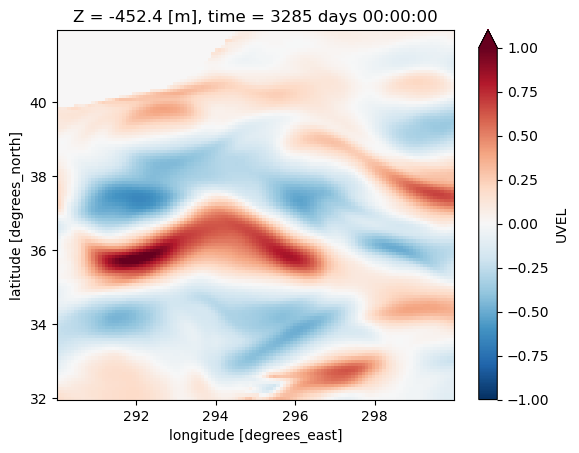

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


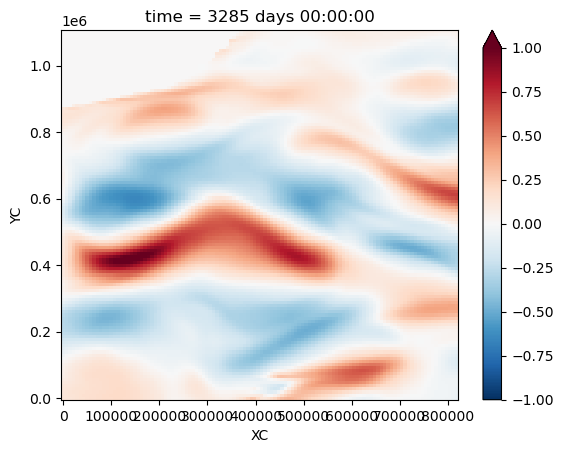

(array([4.38726100e+03, 3.57178002e+03, 2.87848030e+03, 2.29387804e+03,
       1.80539220e+03, 1.40132741e+03, 1.07085618e+03, 8.04000579e+02,
       5.91613170e+02, 4.25357127e+02, 2.97685525e+02, 2.01819631e+02,
       1.31726092e+02, 8.20928525e+01, 4.83036106e+01, 2.64105433e+01,
       1.31049716e+01, 5.68549984e+00, 2.23985211e+00]), -4.368486645310932, -66.15338111102047)


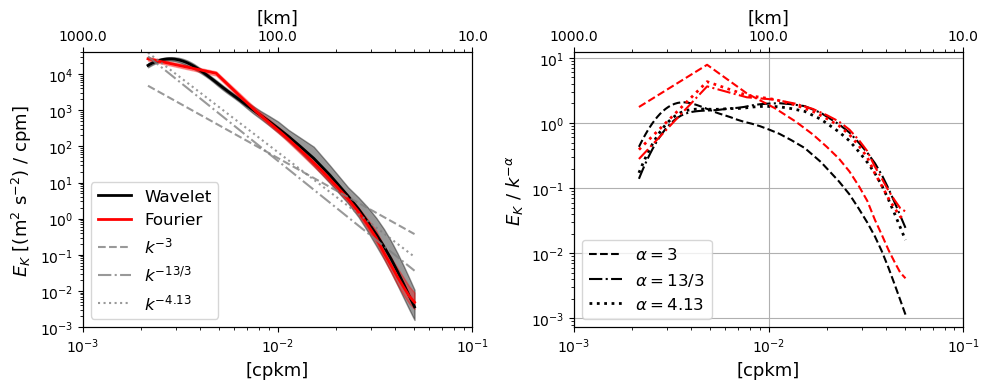

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


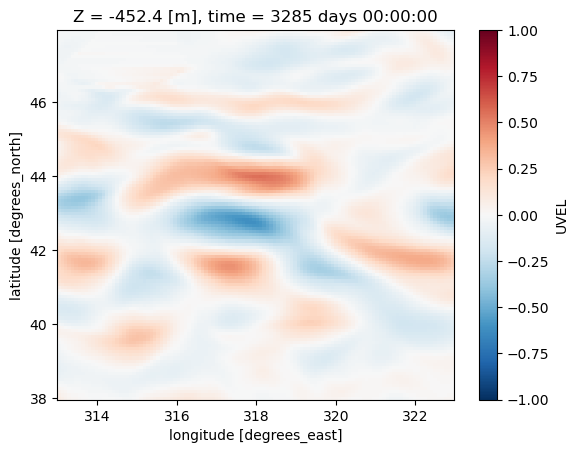

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


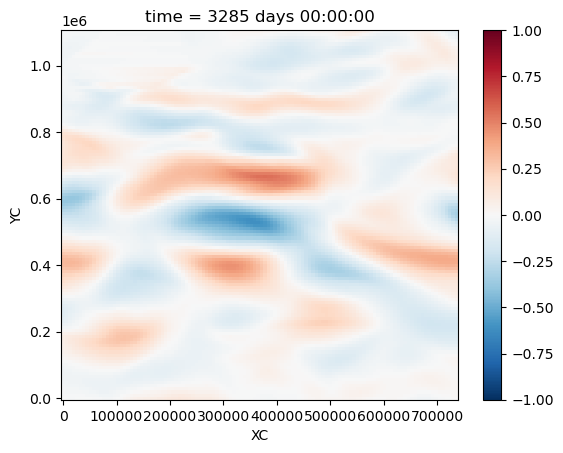

(array([2.12137624e+03, 1.73378765e+03, 1.40367201e+03, 1.12466346e+03,
       8.90839845e+02, 6.96711830e+02, 5.37211698e+02, 4.07681886e+02,
       3.03863194e+02, 2.21882633e+02, 1.58240890e+02, 1.09799366e+02,
       7.37667439e+01, 4.76850217e+01, 2.94149482e+01, 1.71207753e+01,
       9.25421683e+00, 4.53747544e+00, 1.94514948e+00, 1.23040605e+00,
       6.44052637e-01]), -4.505427978177183, -69.61120794584545)


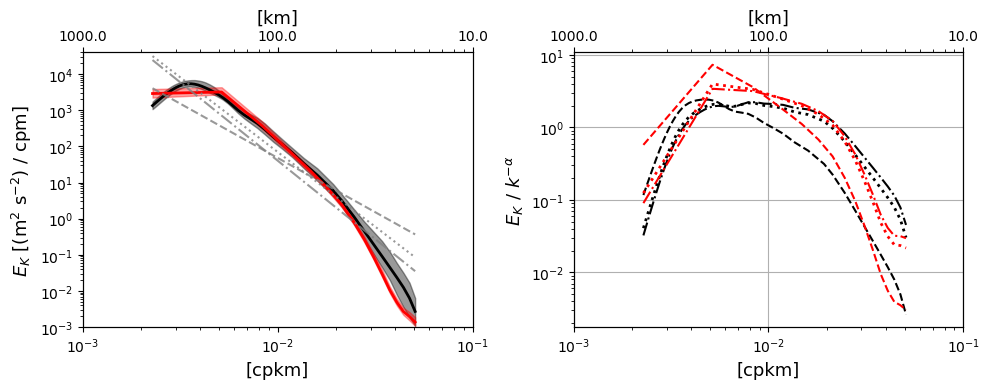

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


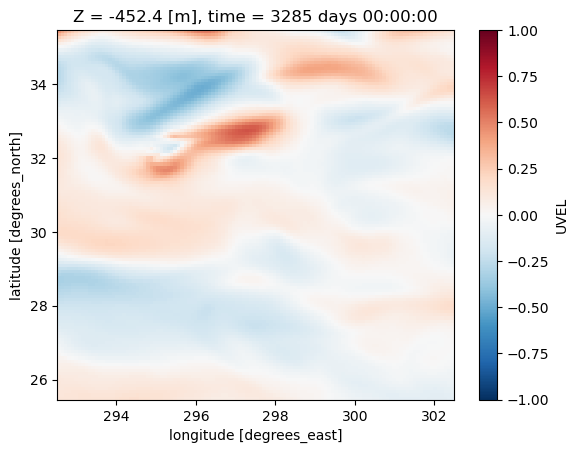

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


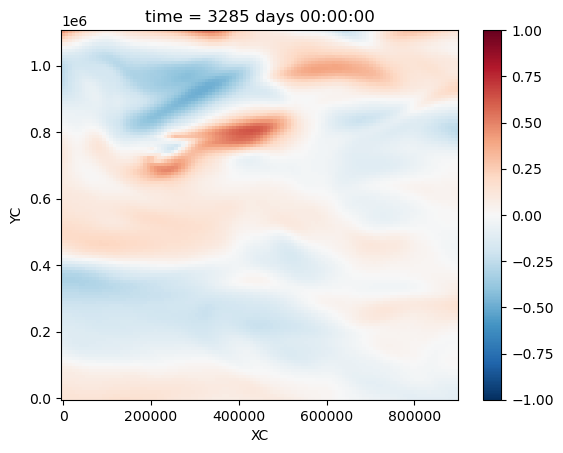

(array([5.51747610e+02, 4.34961000e+02, 3.38405877e+02, 2.59436927e+02,
       1.95629805e+02, 1.44774353e+02, 1.04867611e+02, 7.41066184e+01,
       5.08809795e+01, 3.37651674e+01, 2.15105324e+01, 1.30369802e+01,
       7.42426903e+00, 3.90286831e+00, 1.84429691e+00, 7.50837097e-01,
       2.71683790e-01, 1.52707591e-01]), -4.531967140998128, -72.09854353141935)


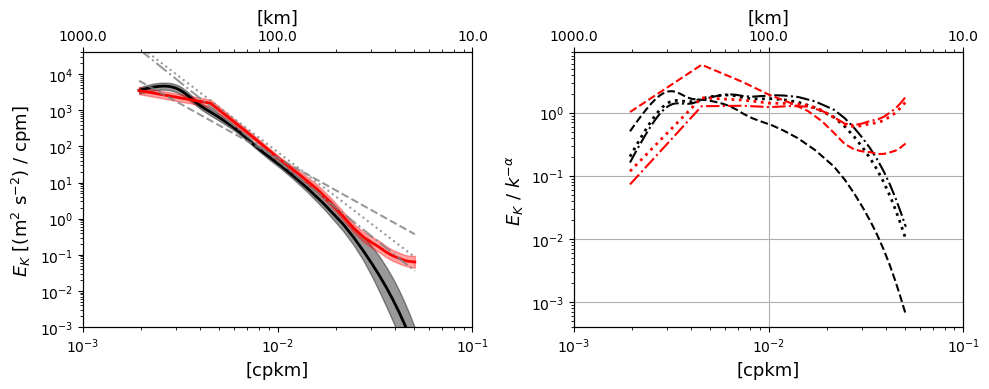

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


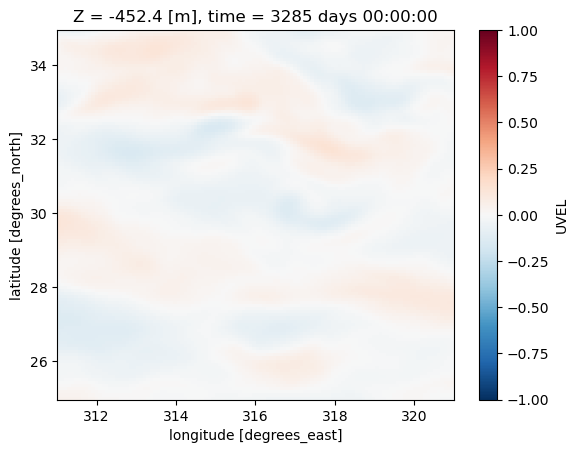

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


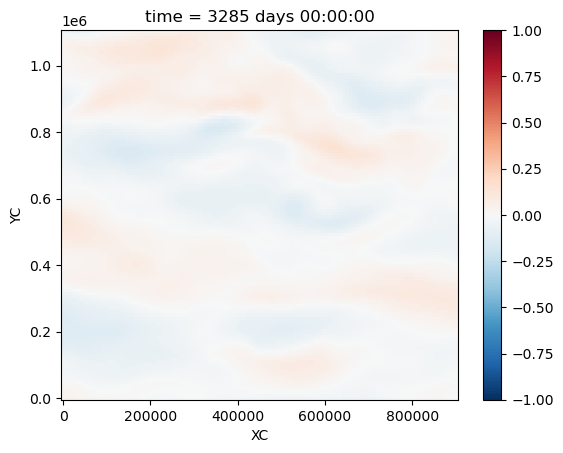

(array([1.42284670e+02, 1.12907235e+02, 8.84547182e+01, 6.83129261e+01,
       5.19149442e+01, 3.87400221e+01, 2.83124191e+01, 2.02002030e+01,
       1.40139998e+01, 9.40568728e+00, 6.06702425e+00, 3.72820816e+00,
       2.15634800e+00, 1.15383885e+00, 5.56618421e-01, 2.32279216e-01,
       8.61741395e-02, 4.93956838e-02]), -4.406564993320808, -71.82705427960813)


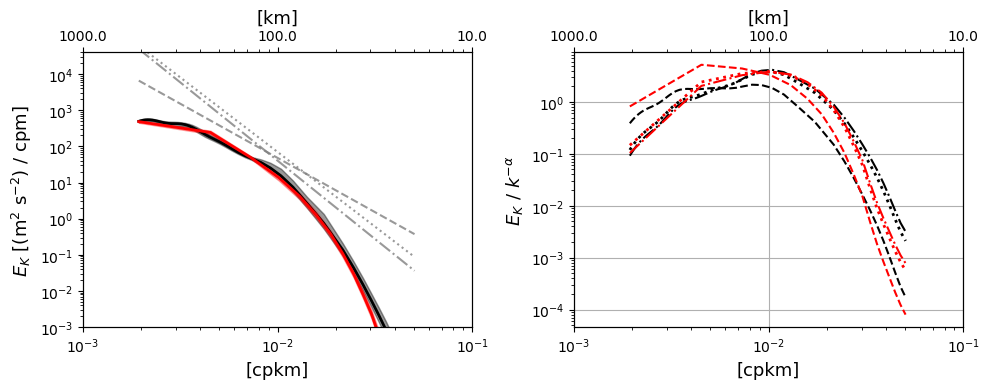

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


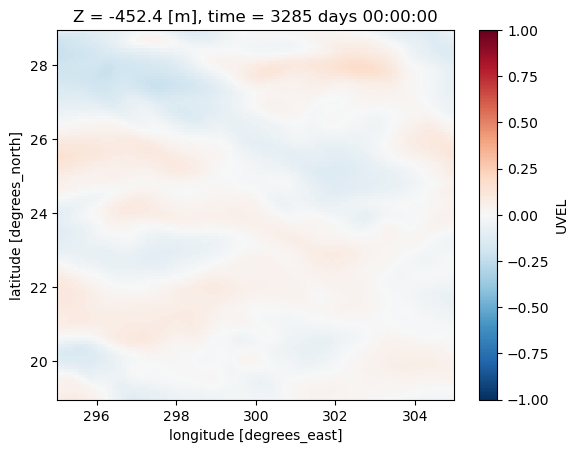

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


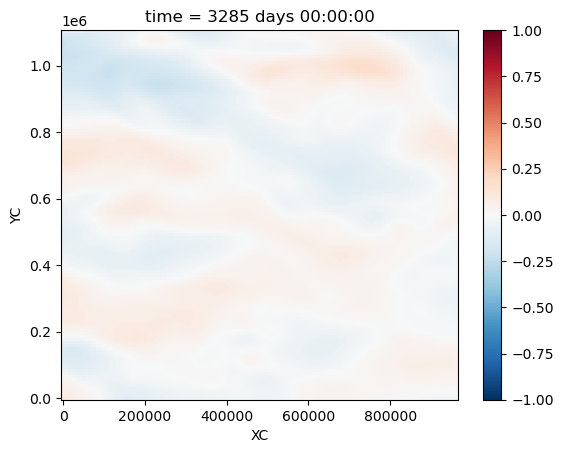

(array([9.80691843e+01, 7.65249866e+01, 5.88471509e+01, 4.45147300e+01,
       3.30509008e+01, 2.40217145e+01, 1.70348022e+01, 1.17380315e+01,
       7.81810719e+00, 4.99910997e+00, 3.04096427e+00, 1.73782392e+00,
       9.16362359e-01, 4.33948876e-01, 1.76685941e-01, 7.05181984e-02,
       4.04736630e-02]), -4.458582715830469, -73.15763571407496)


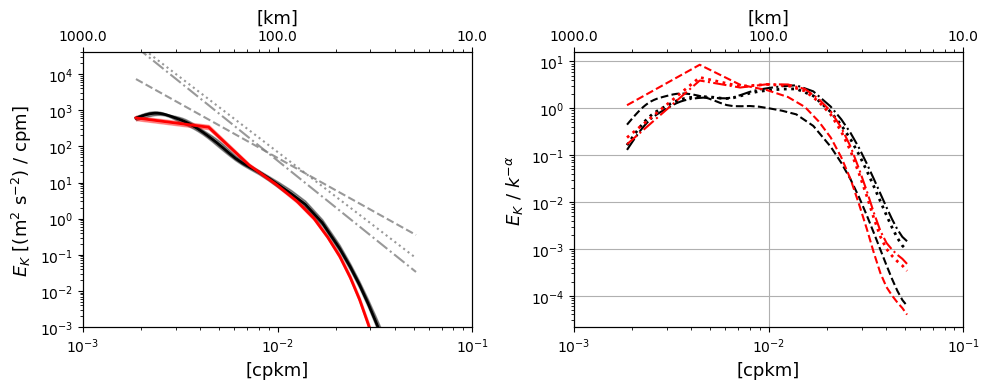

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


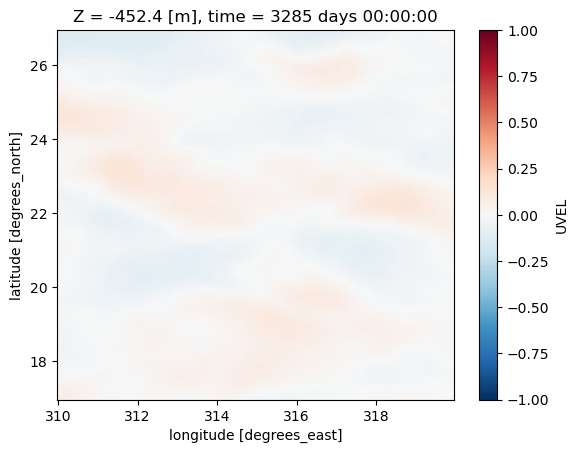

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


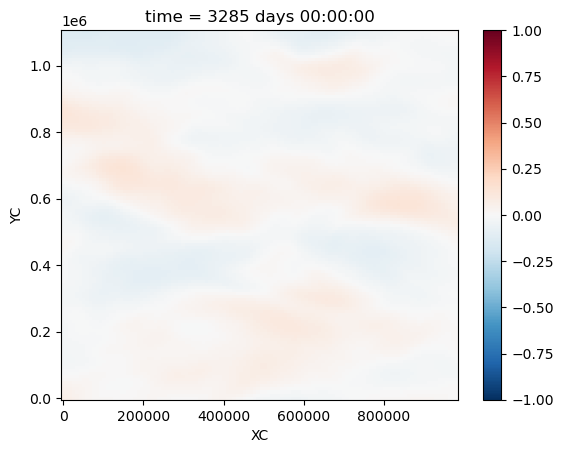

(array([5.81926419e+01, 4.57118806e+01, 3.54007503e+01, 2.69801486e+01,
       2.01927578e+01, 1.48025873e+01, 1.05944947e+01, 7.37368516e+00,
       4.96518586e+00, 3.21329081e+00, 1.98097330e+00, 1.14925952e+00,
       6.16556661e-01, 2.97925897e-01, 1.24287278e-01, 5.09022407e-02,
       2.95337034e-02]), -4.339331100010695, -71.83435700644262)


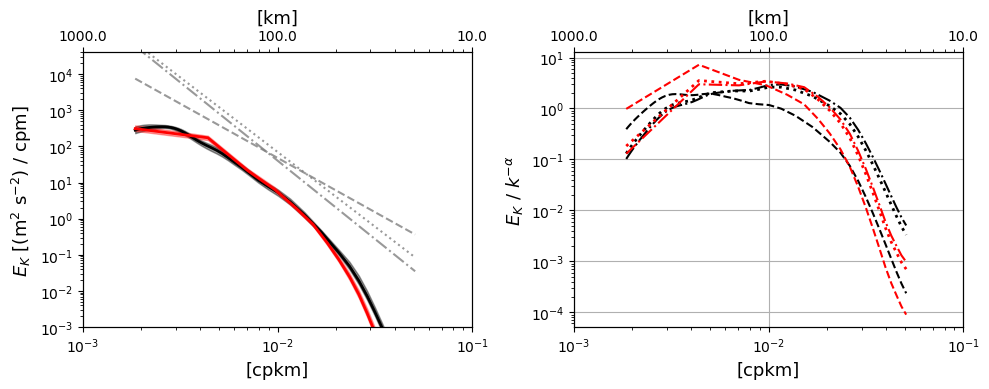

In [19]:
# reg = 3
dg = 1
nmembs = np.arange(100,148)

iiter = ntimes[yystart,::3]
# iiter = 1421280
# iiter = 1423440

for reg in range(len(xs)):
    
    ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                 % (100)), 
                         grid_dir=gdir,
                         prefix=['snap_diagOcn'], delta_t=2e2,
                         iters=iiter, 
                        ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                              YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                              XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                              XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                             ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})


            # ds = ds.chunk({'nmemb':6})
    # if reg == 0:
    #     print(ds)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
        
    grid = Grid(ds, periodic=[])
    
    xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    ny, nx = xT.shape
    xT = xT - xT.isel(XC=nx//2)
    # (xT - xT.isel(YC=-1,XC=0)).plot()
    # plt.show()
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()

    up = grid.interp((ds.UVEL - ds.UVEL.mean('time',skipna=True)).where(ds.maskW!=0.),
                     'X',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)
                          ).load().interpolate_na(dim='XC'
                                                 ).interpolate_na(dim='YC'
                                                                 ).fillna(0.)
    vp = grid.interp((ds.VVEL - ds.VVEL.mean('time',skipna=True)).where(ds.maskS!=0.),
                     'Y',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)
                          ).load().interpolate_na(dim='YC'
                                                 ).interpolate_na(dim='XC'
                                                                 ).fillna(0.)
    up.isel(time=0,Z=1).plot(vmax=1, vmin=-1, cmap='RdBu_r')
    plt.show()
    
    print(ds.dxC.mean(), ds.dyC.mean())
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = up.isel(time=0,Z=0).shape

    uterp = xr.DataArray(np.zeros_like(up.isel(Z=1)), dims=up.isel(Z=1).dims,
                         coords={'time':ds.time,
                                 # 'Z':up.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.zeros_like(vp.isel(Z=1)), dims=vp.isel(Z=1).dims,
                         coords={'time':ds.time,
                                 # 'Z':vp.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.zeros_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
                         dims=ds.rA.dims,
                         coords={'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    #         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
    xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
    for nn in range(len(ds.time)):
        uterp[dict(time=nn)] = griddata((xT, yT), 
                                           (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(time=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 

        vterp[dict(time=nn)] = griddata((xT, yT), 
                                           (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(time=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T

    Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
                     (xxx, yyy) 
                    ).T
    uterp = uterp.chunk({'time':1}) / Aterp
    vterp = vterp.chunk({'time':1}) / Aterp
    uterp.isel(time=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
    plt.show()
    
    iso_psUf = xrft.isotropic_power_spectrum(
                    uterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                    dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
    ) 
    iso_psVf = xrft.isotropic_power_spectrum(
                    vterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                    dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
    ) 
#     ss = xr.DataArray(np.linspace(iso_psUf.freq_r[-1].data**-1,iso_psUf.freq_r[0].data**-1,40
#                                  ) / xo,
#                       dims=['scale'], 
#                       coords={'scale':np.linspace(iso_psUf.freq_r[-1].data**-1,
#                                                   iso_psUf.freq_r[0].data**-1,40)/xo}
#     )
#     ssf = xr.DataArray(iso_psUf.freq_r.data**-1/xo, dims=['scale'], 
#                        coords={'scale':iso_psUf.freq_r.data**-1/xo}
#                       )
#     ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
#                      ssf.where(ssf<50e3/xo).dropna('scale')
#                     ], 'scale')
#     print(len(ssf),len(ssh))
#     iso_psUw = xwavelet.wvlt_power_spectrum(
#                     uterp, ssh, dim=["YC", "XC"], 
#                     xo=xo, ntheta=ntheta
#     ) 
#     iso_psVw = xwavelet.wvlt_power_spectrum(
#                     vterp, ssh, dim=["YC", "XC"], 
#                     xo=xo, ntheta=ntheta
#     )
    
#     dsave = iso_psUw.to_dataset(name='U')
#     dsave['V'] = iso_psVw
#     dsave.to_zarr(
#         '/tank/topog/tuchida/Wavelet-spectrum/memb100/isoDiags_KE_region%02d_1967.zarr' 
#                   % (reg), mode='w')
    
    dsw = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/memb100/isoDiags_KE_region%02d_1967.zarr' 
                       % (reg))
    iso_psUw = dsw.U
    iso_psVw = dsw.V
    print(xrft.fit_loglog((dsw.scale.sel(scale=slice(250e3,40e3))).values**-1,
                          (iso_psUw + iso_psVw
                          ).mean(['time','angle']).sel(scale=slice(250e3,40e3)).values
         ))
            
    w3 = (.5*(iso_psUw + iso_psVw).mean(['time','angle'])
          / ((iso_psUw.scale)**-1)**-3)
    w133 = (.5*(iso_psUw + iso_psVw).mean(['time','angle'])
            / ((iso_psUw.scale)**-1)**(-13/3))
    w413 = (.5*(iso_psUw + iso_psVw).mean(['time','angle'])
            / ((iso_psUw.scale)**-1)**(-4.13))
    f3 = (.5*(iso_psUf + iso_psVf).mean(['time'])
          / (iso_psUf.freq_r)**-3)
    f133 = (.5*(iso_psUf + iso_psVf).mean(['time'])
            / (iso_psUf.freq_r)**(-13/3))
    f413 = (.5*(iso_psUf + iso_psVf).mean(['time'])
            / (iso_psUf.freq_r)**(-4.13))

    
    datas = (.5*(iso_psUw + iso_psVw).sum('angle')
             * np.diff(iso_psVw.angle)[0]*2,
            )  # samples must be in a sequence
    rng = np.random.default_rng()
    Wres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    datas = (.5*(iso_psUf + iso_psVf) * 2*np.pi,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Fres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    
    fig, (ax1,ax3) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
    fig.set_tight_layout(True)
    ax2 = ax1.twiny()
    ax4 = ax3.twiny()
    
    ax1.fill_between((iso_psUw.scale)**-1*1e3, 
                     Wres.confidence_interval.low, Wres.confidence_interval.high, 
                     alpha=.4, color='k')
    ax1.fill_between((iso_psUf.freq_r)*1e3, 
                     Fres.confidence_interval.low, Fres.confidence_interval.high, 
                     alpha=.36, color='r')
    
    ax1.plot((iso_psUw.scale)**-1*1e3, 
             .5*(iso_psUw + iso_psVw).mean(['time']).sum('angle')
             * np.diff(iso_psVw.angle)[0]*2,
             'k', lw=2, label=r"Wavelet")
    ax1.plot((iso_psUf.freq_r)*1e3, 
             .5*(iso_psUf + iso_psVf).mean(['time']) * 2*np.pi,
             'r', lw=2, label=r"Fourier")
    ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-3*6e0, 
             ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
    ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-(13/3)*2e0, 
             ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
    ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-(4.13)*4e0, 
             ls=':', c='grey', alpha=.8, label=r"$k^{-4.13}$")
            
    ax3.plot((iso_psUw.scale)**-1*1e3, w3/w3.mean(),
             'k--', label=r"$\alpha=3$")
    ax3.plot((iso_psUw.scale)**-1*1e3, w133/w133.mean(),
             'k-.', label=r"$\alpha=13/3$")
    ax3.plot((iso_psUw.scale)**-1*1e3, w413/w413.mean(),
             'k:', lw=2, label=r"$\alpha=4.13$")
    ax3.plot((iso_psUf.freq_r)*1e3, f3/f3.mean(),
             'r--', label=r"")
    ax3.plot((iso_psUf.freq_r)*1e3, f133/f133.mean(),
             'r-.', label=r"")
    ax3.plot((iso_psUf.freq_r)*1e3, f413/f413.mean(),
             'r:', lw=2, label=r"")

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax1.set_ylim([1e-3,4e4])
    ax1.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax3.set_xlim([1e-3,1e-1])
    ax4.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    ax4.set_xticks([1e-3,1e-2,1e-1])
    ax4.set_xticklabels([1e3,1e2,1e1])
    ax1.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax1.set_ylabel(r"$E_K$ [(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
    ax3.set_xlabel(r"[cpkm]", fontsize=13)
    ax4.set_xlabel(r"[km]", fontsize=13)
    ax3.set_ylabel(r"$E_K~/~k^{-\alpha}$", fontsize=13)
    if reg == 0:
        ax1.legend(loc='lower left', fontsize=12)
        ax3.legend(loc='lower left', fontsize=12)
    ax3.grid(True)
    plt.savefig(op.join(
    '/tank/topog/tuchida/Wavelet-spectrum/Figs/WvsF-KE-spec_Region%02d_integrated_Z452_memb100-1967.pdf' 
                        % (reg))
               )
    plt.show()

In [12]:
reg = 0
dg = 1
nmembs = np.arange(100,148)

for reg in range(len(xs)):
    
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=1419120, 
                         ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                               YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                               XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                               XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=1419120, 
                                ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                      XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=1419120, 
                                               ).sel(YC=slice(ys[reg]-5-dg/12,
                                                              ys[reg]+5+dg/12),
                                                     YG=slice(ys[reg]-5-dg/12,
                                                              ys[reg]+5+dg/12),
                                                     XC=slice(xs[reg]-5-dg/12,
                                                              xs[reg]+5+dg/12),
                                                     XG=slice(xs[reg]-5-dg/12,
                                                              xs[reg]+5+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,
                                                             'Zp1':1}).isel(time=0)
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    # if reg == 0:
    #     print(ds)
    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
        ds = ds.isel(XG=slice(None,-1))
        
    grid = Grid(ds, periodic=[])
    
    xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    ny, nx = xT.shape
    xT = xT - xT.isel(XC=nx//2)
    # (xT - xT.isel(YC=-1,XC=0)).plot()
    # plt.show()
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()

    up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                     'X',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)
                          ).load().interpolate_na(dim='XC'
                                                 ).interpolate_na(dim='YC'
                                                                 ).fillna(0.)
    vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                     'Y',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)
                          ).load().interpolate_na(dim='YC'
                                                 ).interpolate_na(dim='XC'
                                                                 ).fillna(0.)
    up.isel(nmemb=0,Z=1).plot(vmax=.8, vmin=-.8, cmap='RdBu_r')
    plt.show()
    
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = up.isel(nmemb=0,Z=0).shape

    uterp = xr.DataArray(np.zeros_like(up.isel(Z=1)), dims=up.isel(Z=1).dims,
                         coords={'nmemb':nmembs,
                                 # 'Z':up.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.zeros_like(vp.isel(Z=1)), dims=vp.isel(Z=1).dims,
                         coords={'nmemb':nmembs,
                                 # 'Z':vp.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.zeros_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
                         dims=ds.rA.dims,
                         coords={'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )

    xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
    for nn in range(len(nmembs)):

        uterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
                                           (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(nmemb=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 

        vterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
                                           (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(nmemb=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T

    Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
                     (xxx, yyy) 
                    ).T
    uterp = uterp / Aterp
    vterp = vterp / Aterp
    uterp.isel(nmemb=0).plot(vmax=.8, vmin=-.8, cmap='RdBu_r', rasterized=True)
    plt.show()
    
    iso_psUf = xrft.isotropic_power_spectrum(
                    uterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                    dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
    ) 
    iso_psVf = xrft.isotropic_power_spectrum(
                    vterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                    dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
    ) 
    ss = xr.DataArray(np.linspace(iso_psUf.freq_r[-1].data**-1,iso_psUf.freq_r[0].data**-1,40)/xo,
                      dims=['scale'], 
                      coords={'scale':np.linspace(iso_psUf.freq_r[-1].data**-1,
                                                  iso_psUf.freq_r[0].data**-1,40)/xo}
    )
    ssf = xr.DataArray(iso_psUf.freq_r.data**-1/xo, dims=['scale'], 
                       coords={'scale':iso_psUf.freq_r.data**-1/xo}
                      )
    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                     ssf.where(ssf<50e3/xo).dropna('scale')
                    ], 'scale')
    print(len(ssf),len(ssh))
    iso_psUw = xwavelet.wvlt_power_spectrum(
                    uterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    ) 
    iso_psVw = xwavelet.wvlt_power_spectrum(
                    vterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    )
    
    if reg > 1:
        dsave = iso_psUw.to_dataset(name='U')
        dsave['V'] = iso_psVw
        dsave.to_zarr(
            '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                      % reg, mode='w')

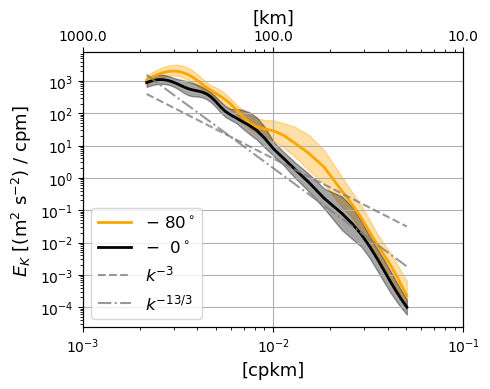

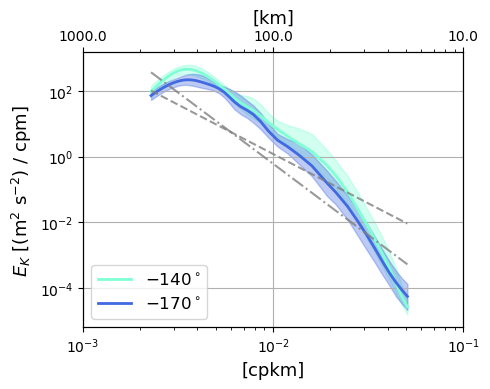

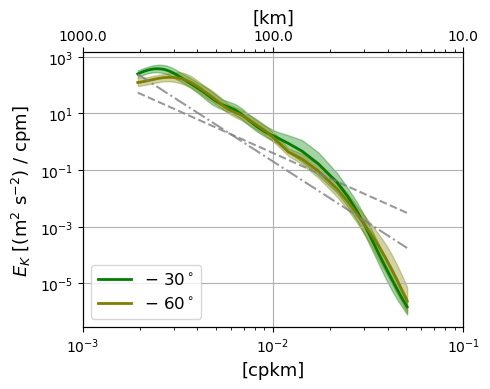

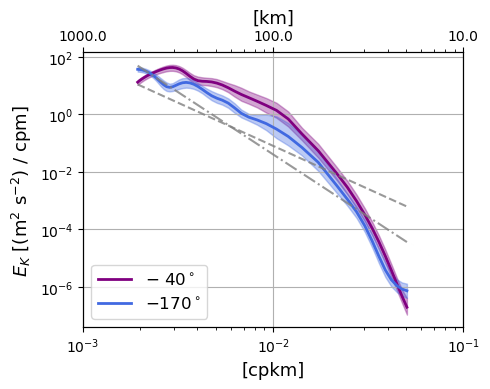

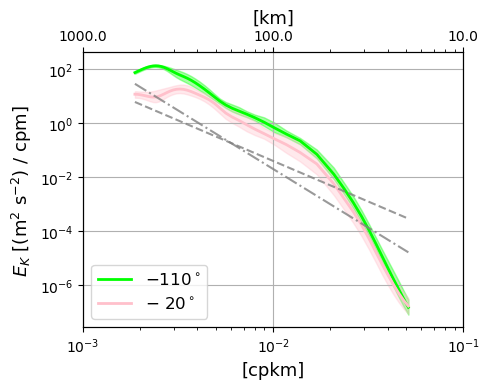

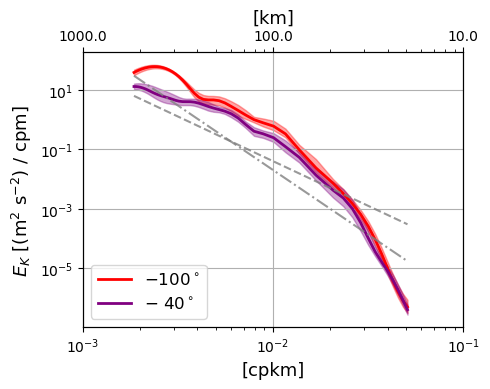

In [21]:
reg = 0
dg = 1
nmembs = np.arange(100,148)
amps = [.1,.03,.01,.002,.001,.001]

for reg in range(len(xs)):
    
    dsw = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/memb100/isoDiags_KE_region%02d_1967.zarr'
                       % reg)
    iso_psUw = dsw.U
    iso_psVw = dsw.V
    dks = xr.DataArray(np.abs(np.diff(dsw.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(dsw.scale[1:].data + dsw.scale[:-1].data)}
                      ).interp(scale=dsw.scale, kwargs={"fill_value":"extrapolate"})
    E = .5*((iso_psUw + iso_psVw) * dks).sum('scale').mean('time')
    iM = np.argmax(E.data)
    im = np.argmin(E.data)
    
    angles = np.linspace(0,180,18,endpoint=False)
    colors = ['k','brown','pink','g','purple','gold',
              'olive','b','orange','magenta','r','lime',
              'violet','cyan','aquamarine','peru','indianred','royalblue'
             ]
    fig, ax1 = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    ax2 = ax1.twiny()
    
    for ag in np.array([iM,im]):
        
        datas = (.5*(iso_psUw + iso_psVw).isel(angle=ag)*np.diff(iso_psVw.angle)[0]*2,
                )  # samples must be in a sequence
        rng = np.random.default_rng()
        Wres = bootstrap(datas, np.mean, confidence_level=0.95,
                         random_state=rng)
        ax1.fill_between((iso_psUw.scale)**-1*1e3, 
                         Wres.confidence_interval.low, Wres.confidence_interval.high, 
                         alpha=.35, color=colors[ag])
    
        ax1.plot((iso_psUw.scale)**-1*1e3, 
                 .5*(iso_psUw + iso_psVw).isel(angle=ag).mean(['time'])
                 * np.diff(iso_psVw.angle)[0]*2,
                 lw=2, c=colors[ag], label=r"$-$%3d$^\circ$" % angles[ag])
    if reg == 0:
        ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-3*5e0*amps[reg],
                     ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-(13/3)*1e0*amps[reg], 
                     ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
    else:
        ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-3*5e0*amps[reg],
                 ls='--', c='grey', alpha=.8,)
        ax1.plot((iso_psUw.scale)**-1*1e3, ((iso_psUw.scale/xo)**-1)**-(13/3)*1e0*amps[reg], 
                 ls='-.', c='grey', alpha=.8,)
            

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax1.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    ax1.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax1.set_ylabel(r"$E_K$ [(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
    # if reg == 0:
    ax1.legend(loc='lower left', fontsize=12)
    ax1.grid(True)
    plt.savefig(op.join(
        '/tank/topog/tuchida/Wavelet-spectrum/Figs/Wavelet-KE-spec_Region%02d_angles_memb100_1967_Z452.pdf' 
                        % reg)
               )
    plt.show()
    plt.close()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/

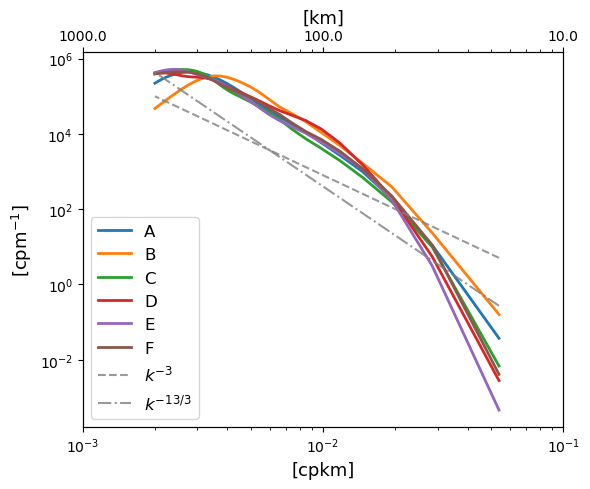

In [23]:
nmembs = np.arange(100,148)
xchunk = 100
ychunk = 100
dg = 1

yy = yystart
locs = ['A','B','C','D','E','F']

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax2 = ax.twiny()
for reg in range(len(xs)):
    
    # ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
    # ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
    # # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    # dks = xr.DataArray(np.abs(np.diff(ds1.scale**-1)).data, dims='scale',
    #                    coords={'scale':.5*(ds1.scale[1:].data + ds1.scale[:-1].data)}
    #                   ).interp(scale=ds1.scale, kwargs={"fill_value": "extrapolate"})
    # Ak = (ds0.iso_uA + ds1.iso_vA
    #       - (ds4.iso_uA + ds4.iso_vA))
    # piw = ((Ak) * dks).cumsum('scale').mean('nmemb')
    # piw = piw.where((piw.scale)**-1<1e-5).sum('scale',skipna=True).compute()
    
    ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                 % (100)), 
                         grid_dir=gdir,
                         prefix=['snap_diagOcn'], delta_t=2e2,
                         iters=iiter, 
                        ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                              YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                              XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                              XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                             ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
    
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    
    grid = Grid(ds, periodic=False)
    # print(ds,grid)

    up = grid.interp((ds.UVEL - ds.UVEL.mean('time',skipna=True)).where(ds.maskW!=0.),
                     'X',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
    vp = grid.interp((ds.VVEL - ds.VVEL.mean('time',skipna=True)).where(ds.maskS!=0.),
                     'Y',boundary='extend'
                    ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
    # up.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
    # plt.show()
    
    xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    xT = (xT - xT.isel(XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = up.isel(time=0,Z=0).shape
    ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
                      coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
            )
    
    uterp = xr.DataArray(np.ones_like(up.isel(Z=1)), dims=up.isel(Z=-1).dims,
                         coords={'time':ds.time,
                                 # 'Z':up.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
            )
    vterp = xr.DataArray(np.ones_like(vp.isel(Z=1)), dims=vp.isel(Z=-1).dims,
                         coords={'time':ds.time,
                                 # 'Z':vp.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
            )
    Aterp = xr.DataArray(np.ones_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
                         dims=ds.rA.dims,
                         coords={'YC':np.arange(0,N[-2]*dx,dx),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
            )
    #         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    for nn in range(len(ds.time)):
        uterp.isel(time=nn)[:] = griddata((xT, yT), 
                                           (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(time=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 
        vterp.isel(time=nn)[:] = griddata((xT, yT), 
                                           (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
                                           ).isel(time=nn,Z=1).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 
            
    Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
                     (xxx, yyy) 
                    ).T
    uterp = uterp.chunk({'time':1}) / Aterp
    vterp = vterp.chunk({'time':1}) / Aterp
    # uterp.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
    # plt.show()
    #             print(nn)


    iso_psU = xwavelet.wvlt_power_spectrum(
                    uterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    )
    iso_psV = xwavelet.wvlt_power_spectrum(
                    vterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    )

    
    ps = .5*(iso_psU + iso_psV).mean('time').sum('angle')
    dks = xr.DataArray(np.abs(np.diff(ps.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ps.scale[1:].data + ps.scale[:-1].data)}
                      ).interp(scale=ps.scale, kwargs={"fill_value": "extrapolate"})
    ax.plot((iso_psU.scale)**-1*1e3, ps/(ps*dks).sum(),
            lw=2, label=locs[reg]
           )

ax.plot((ps.scale)**-1*1e3, ((ps.scale/xo)**-1)**-3*1e2, 
        ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
ax.plot((ps.scale)**-1*1e3, ((ps.scale/xo)**-1)**-(13/3)*2e1, 
        ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.set_xlim([1e-3,1e-1])
ax2.set_xlim([1e-3,1e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e3,1e2,1e1])
ax.set_xlabel(r"[cpkm]", fontsize=13)
ax2.set_xlabel(r"[km]", fontsize=13)
ax.set_ylabel(r"[cpm$^{-1}$]", fontsize=13)
ax.legend(loc='lower left', fontsize=12)
plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/NormalizedSnapKE-spec_memb100-1967_Z452.pdf'))
plt.show()

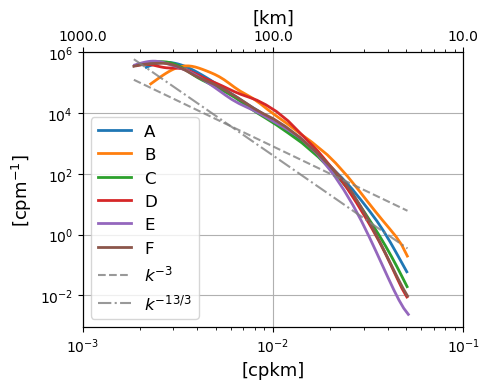

In [26]:
nmembs = np.arange(100,148)
xchunk = 100
ychunk = 100
dg = 1

yy = yystart
locs = ['A','B','C','D','E','F']

fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)
ax2 = ax.twiny()
for reg in range(len(xs)):
    dsw = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/memb100/isoDiags_KE_region%02d_1967.zarr'
                       % reg)
    iso_psUw = dsw.U
    iso_psVw = dsw.V
#     # dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
#     #                               grid_dir=gdir,
#     #                               prefix=['snap_diagOcn'], delta_t=2e2,
#     #                               iters=1419120, 
#     #                              ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#     #                                                 YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#     #                                                 XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
#     #                                                 XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
#     #                                                )
    
#     # ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
#     # ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
#     # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
#     # dks = xr.DataArray(np.abs(np.diff(ds1.scale**-1)).data, dims='scale',
#     #                    coords={'scale':.5*(ds1.scale[1:].data + ds1.scale[:-1].data)}
#     #                   ).interp(scale=ds1.scale, kwargs={"fill_value": "extrapolate"})
#     # Ak = (ds0.iso_uA + ds1.iso_vA
#     #       - (ds4.iso_uA + ds4.iso_vA))
#     # piw = ((Ak) * dks).cumsum('scale').mean('nmemb')
#     # piw = piw.where((piw.scale)**-1<1e-5).sum('scale',skipna=True).compute()
    
#     for nmemb in nmembs:
#         if nmemb == 100:
#             ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
#                                          % (nmemb)), 
#                                  grid_dir=gdir,
#                                  prefix=['snap_diagOcn'], delta_t=2e2,
#                                  iters=1419120, 
#                                 ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                                                    YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                                                    XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
#                                                    XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
#                                                   )
#         else:
#             ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
#                                                         % (nmemb)), 
#                                                 grid_dir=gdir,
#                                                 prefix=['snap_diagOcn'], delta_t=2e2,
#                                                 iters=1419120, 
#                                                ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,
#                                                                            ys[reg]+5+dg/12),
#                                                                   YG=slice(ys[reg]-5-dg/12,
#                                                                            ys[reg]+5+dg/12),
#                                                                   XC=slice(xs[reg]-5-dg/12,
#                                                                            xs[reg]+5+dg/12),
#                                                                   XG=slice(xs[reg]-5-dg/12,
#                                                                            xs[reg]+5+dg/12)
#                                                                  )
#                            ], dim='nmemb')

#             # ds = ds.chunk({'nmemb':6})
#     ds.coords['nmemb'] = ('nmemb',nmembs)
#     if len(dsb.XG) > len(dsb.XC):
#         dsb = dsb.isel(XG=slice(None,-1))
#         ds = ds.isel(XG=slice(None,-1))
    
#     grid = Grid(ds, periodic=False)
#     # print(ds,grid)

#     up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
#                      'X',boundary='extend'
#                     ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
#     vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
#                      'Y',boundary='extend'
#                     ).isel(Z=[14,18,24],YC=slice(dg,-dg),XC=slice(dg,-dg)).load()
#     # up.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
#     # plt.show()
    
#     xT = grid.cumsum(ds.dxC,'X',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#     yT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#     xT = (xT - xT.isel(XC=0)).values.flatten()
#     yT = (yT - yT.isel(YC=0)).values.flatten()
    
#     dx = ds.dxC.min().values
#     dy = ds.dyC.min().values
#     N = up.isel(nmemb=0,Z=0).shape
#     ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
#                       coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
#             )
    
#     uterp = xr.DataArray(np.ones_like(up.isel(Z=1)), dims=up.isel(Z=-1).dims,
#                          coords={'nmemb':nmembs,
#                                  # 'Z':up.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#             )
#     vterp = xr.DataArray(np.ones_like(vp.isel(Z=1)), dims=vp.isel(Z=-1).dims,
#                          coords={'nmemb':nmembs,
#                                  # 'Z':vp.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#             )
#     Aterp = xr.DataArray(np.ones_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
#                          dims=ds.rA.dims,
#                          coords={'YC':np.arange(0,N[-2]*dx,dx),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#             )
#     #         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
#     xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
#     for nn in range(len(nmembs)):
# #         for iz in range(len(up.Z)):

# #             uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
# #                                                     (up*ds.rA.isel(YC=slice(dg,-dg),
# #                                                                    XC=slice(dg,-dg))
# #                                                     ).isel(nmemb=nn,Z=iz).values.flatten(),
# #                                                     (xxx, yyy) 
# #                                                    ).T 

# #             vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
# #                                                     (vp*ds.rA.isel(YC=slice(dg,-dg),
# #                                                                    XC=slice(dg,-dg))
# #                                                     ).isel(nmemb=nn,Z=iz).values.flatten(),
# #                                                     (xxx, yyy) 
# #                                                    ).T 
#         uterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
#                                            (up*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#                                            ).isel(nmemb=nn,Z=1).values.flatten(),
#                                            (xxx, yyy) 
#                                           ).T 
#         vterp.isel(nmemb=nn)[:] = griddata((xT, yT), 
#                                            (vp*ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
#                                            ).isel(nmemb=nn,Z=1).values.flatten(),
#                                            (xxx, yyy) 
#                                           ).T 
            
#     Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))).values.flatten(),
#                      (xxx, yyy) 
#                     ).T
#     uterp = uterp / Aterp
#     vterp = vterp / Aterp
#     # uterp.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r', rasterized=True)
#     # plt.show()
#     #             print(nn)


#     iso_psU = xwavelet.wvlt_power_spectrum(
#                     uterp.chunk({'nmemb':1}), ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#     )
#     iso_psV = xwavelet.wvlt_power_spectrum(
#                     vterp.chunk({'nmemb':1}), ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#     )

    
    ps = .5*(iso_psUw + iso_psVw).sum('angle')
    dks = xr.DataArray(np.abs(np.diff(ps.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ps.scale[1:].data + ps.scale[:-1].data)}
                      ).interp(scale=ps.scale, kwargs={"fill_value": "extrapolate"})
    ps = (ps / (ps*dks).sum('scale',skipna=True)).mean('time')
    ax.plot((ps.scale)**-1*1e3, ps,
            lw=2, label=locs[reg]
           )

ax.plot((ps.scale)**-1*1e3, ((ps.scale/xo)**-1)**-3*1e2, 
        ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
ax.plot((ps.scale)**-1*1e3, ((ps.scale/xo)**-1)**-(13/3)*2e1, 
        ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.set_xlim([1e-3,1e-1])
ax.set_ylim([None,1e6])
ax2.set_xlim([1e-3,1e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e3,1e2,1e1])
ax.grid(True)
ax.set_xlabel(r"[cpkm]", fontsize=13)
ax2.set_xlabel(r"[km]", fontsize=13)
ax.set_ylabel(r"[cpm$^{-1}$]", fontsize=13)
ax.legend(loc='lower left', fontsize=12)
plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/NormalizedSnapKE-spec_memb100-1967_Z452.pdf'))
plt.show()